# Pose Estimation
An important task in computer vision is to estimate the pose of a rigid body using images. Similarly to it, we commonly estimate the camera pose given an image. To solve this problem, one of the approaches are to solve the Perspective-n-Problem, a.k.a. PnP. The PnP is a problem, not an algorithm. Given a set of 2D points observed onto the image plane, if we know the 3D points - in the space - that generated these 2D projections, knowing the point-to-point correspondence, we can estimate the camera pose by solving the PnP.

In the drive link sent to you, there are the image and a .txt with the 3D points. Those 3D points are the centroid of each of the presented circles observed in the image. In this task, we want you to solve the PnP and estimate the pose of the observed object on the image and the camera pose as well.

Some tips for you:

The image below presents some circles drawn in the object surface. The 3D points provided for you contains the centroid of each circle that the object has. However, you'll notice that there is 9 3D points in the .txt, and you can observe only 8 on the image. Those 3D points are the centroid of each white circle present in the object. These 3D points are referenced in the centroid of the object. Also, you don't know the points correspondence, i.e., you don't know which point is which. So, some steps that you could follow are:

- Find a way to detect the center of each of the white circles observed on the image. With this, you'll have the 2D points of each circle.
- Given that you know the 2D keypoints obtained in the previous step, you must find the correspondence between the points.
- After you solve the correspondence problem, you know the 2D keypoints and the 3D keypoints. Thus, you need to solve the PnP problem. Fortunately, there are a lot of libraries written in C++ and Python that solve this for you. One of them is the OpenCV. The function cv2.solvePnP. There are other libraries like OpenCV: Kornia and PyColmap. You can choose one of them, but read carefully the documentation.
- When you solve the PnP, you'll have a rotation vector, or rotation matrix - relies on the implementation - and a translation vector. Then, you must estimate the object pose with respect to (w.r.t) the camera frame and the camera pose w.r.t. the world frame.

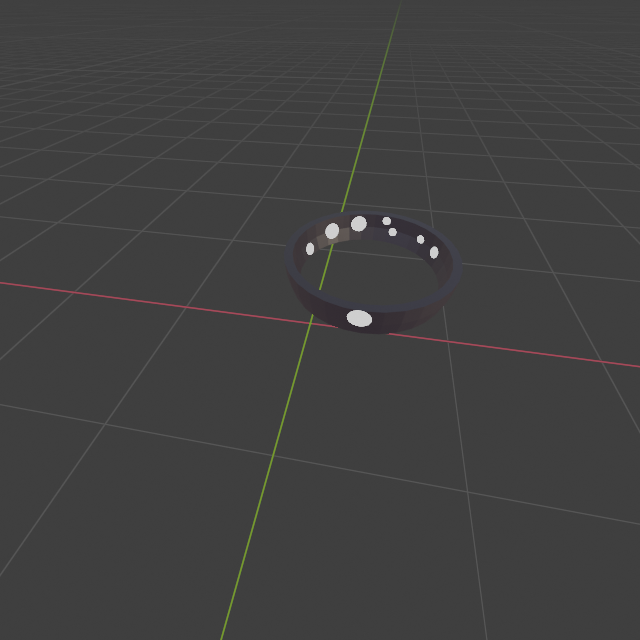

In [1]:
%cd data/
!ls

/home/arthur/Desktop/GitHub/Pose-Estimation/data
3d_keypoints.txt  img.png


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import copy

In [3]:
# NOTE: Do not change the code in this cell
def drawMarkers(img, keypoints, color=(0, 255, 0), markerSize=35, thickness=1):
    """
        Wrapper to draw 2D points onto the image plane easier.

        Parameters:
        -----------
            img : np.array,
                (width, height, 3) image content.
            keypoints : np.array,
                (N, 2) 2D image points.
            color : tuple,
                tuple containing the color as (BLUE, GREEN, RED).
    """

    img_copy = copy.deepcopy(img)

    try:
        img_copy = cv2.cvtColor(img_copy, cv2.COLOR_GRAY2BGR)
    except:
        pass

    for keypoint in keypoints:
        cv2.drawMarker(
            img_copy,
            tuple([int(keypoint[0]), int(keypoint[1])]),
            color,
            markerType=cv2.MARKER_CROSS,
            markerSize=markerSize,
            thickness=thickness,
            line_type=cv2.LINE_AA
        )

    return img_copy

def project(K, R, t, p3d):
    """
        Project 3D points onto the image plane.

        Parameters:
        -----------
            K : np.array,
                (3, 3) camera intrinsics matrix.
            R : np.array,
                (3, 3) rotation matrix that brings the object frame to 
                camera frame.
            t : np.array,
                (3, 1) translation vector that brings the object frame 
                to camera frame.
            p3d : np.array,
                (N, 3) 3d object points.
        
        Returns:
        --------
            (N, 2) projected image points as type int32.
    """

    assert K.shape == (3, 3)
    assert R.shape == (3, 3)
    assert t.shape == (3, 1)
    assert p3d.shape[1] == 3

    p2d = (K @ (R @ p3d.T + t)).T
    p2d = p2d / p2d[:, -1:]

    return np.int32(p2d[..., :2])

In [4]:
# NOTE: Do not change the variables in this cell
camera_fov_deg = 90.0
camera_fov_rad = 90.0 * np.pi / 180.0

width = 640
height = 640

fx = width / (2 * np.tan(camera_fov_rad / 2.0))
fy = height / (2 * np.tan(camera_fov_rad / 2.0))

# K extends for the intrinsics camera matrix
K = np.array([
    [fx, 0.0, width / 2.0],
    [0.0, fy, height / 2.0],
    [0.0, 0.0, 1.0]
])

# The below variables you can change
img_path = "./img.png"
keypoints_path = "./3d_keypoints.txt"

keypoints3D = np.loadtxt(keypoints_path)
img = cv2.imread(img_path)

## Get 2D keypoints

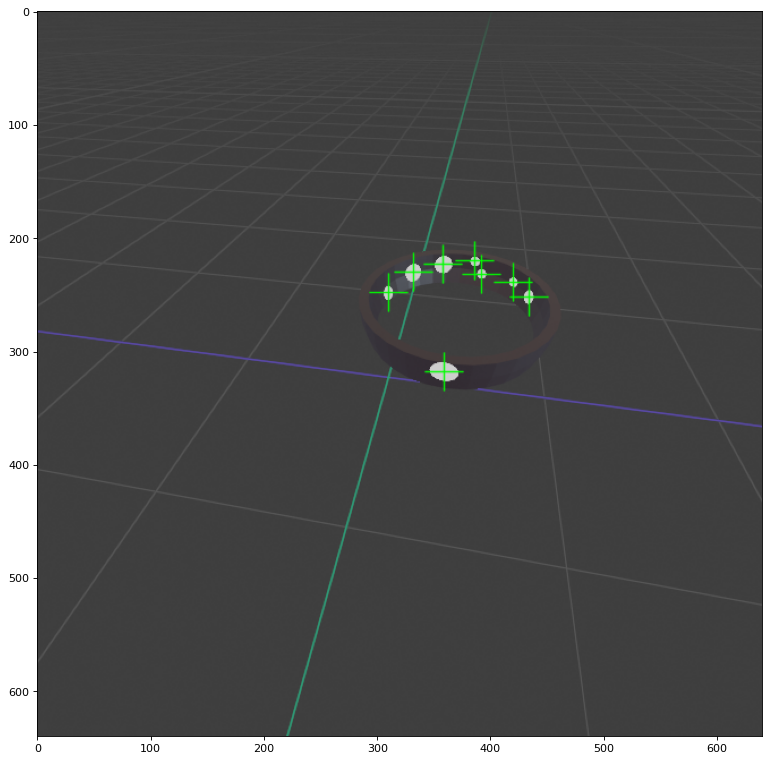

In [5]:
# Write your code in this cell. You can use how many cells you want.
def find_centroids(img):
    # Get the white marks on image
    lower_white = np.array([255, 255, 255])
    upper_white = np.array([155, 155, 155])

    mask = cv2.inRange(img, upper_white, lower_white)

    # The contours on the mask are the white circles
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the centroids for each circle
    centroids_2d = list()

    for contour in contours:
        moment = cv2.moments(contour)

        circle_center = (round(moment['m10'] / moment['m00']), 
                         round(moment['m01'] / moment['m00']))

        centroids_2d.append(circle_center)

        # cv2.circle(img_copy, circle_center, 1, (255, 0, 0), -1)

    # cv2.drawContours(img_copy, contours, -1, (0,255,0), 1)

    return np.array(centroids_2d)


keypoints2D = find_centroids(img)

img_points = drawMarkers(img, keypoints2D)
plt.figure(figsize=(16, 12), dpi=80)
plt.imshow(img_points)
plt.show() 

## Match the 2D keypoints to the 3D keypoints

This cell implement a heuristic to pair the 2D points with the 3D points available. This technique considers the extremities of the X and Y axis, taking into account that the Y axis is inverted on the 2D plane when compared to the 3D plane. This way, we are able to obtain 4 matching keypoints.

In [6]:
keypoints2D_copy = copy.deepcopy(keypoints2D)
keypoints3D_copy = copy.deepcopy(keypoints3D)


def match_2d_points_to_3d(keypoints2D, keypoints3D):
    matching_keypoints = list()

    # Order keypoints according to Y    
    keypoints2D = keypoints2D[keypoints2D[:, 1].argsort()]
    keypoints3D = keypoints3D[keypoints3D[:, 1].argsort()]

    # Max Y 2D is the same point as min Y 3D
    max_y_2d = keypoints2D[-1]
    min_y_3d = keypoints3D[0]

    matching_keypoints.append((max_y_2d, min_y_3d))

    # Min Y 2D is the same as max Y value 3D
    min_y_2d = keypoints2D[0]
    max_y_3d = keypoints3D[-1]

    matching_keypoints.append((min_y_2d, max_y_3d))

    # Order keypoints according to X
    keypoints2D = keypoints2D[keypoints2D[:, 0].argsort()]
    keypoints3D = keypoints3D[keypoints3D[:, 0].argsort()]

    # Min X 2D is the same min X 3D value    
    min_x_2d = keypoints2D[0]
    min_x_3d = keypoints3D[0]

    matching_keypoints.append((min_x_2d, min_x_3d))

    # Max X 2D is the same max X 3D value
    max_x_2d = keypoints2D[-1]
    max_x_3d = keypoints3D[-1]

    matching_keypoints.append((max_x_2d, max_x_3d))

    return matching_keypoints
    

matching_keypoints = match_2d_points_to_3d(keypoints2D_copy, keypoints3D_copy)
matching_keypoints

[(array([359, 318]), array([ 0.36196, -0.52922,  0.63917])),
 (array([386, 220]), array([0.45613, 0.39859, 0.66708])),
 (array([310, 248]), array([-0.013788,  0.12311 ,  0.57    ])),
 (array([434, 252]), array([0.78335, 0.22951, 0.60298]))]

## Estimate the pose with the 4 matching points identified

The SOLVEPNP_P3P algorithm was empolyed to solve the PnP problem, as only 4 matching keypoints are available.

In [7]:
def get_object_and_image_points(matching_keypoints):
    object_points = list()
    image_points = list()
    
    for image_point, object_point in matching_keypoints:
        object_points.append(object_point)
        image_points.append(image_point)

    return object_points, image_points


def estimate_pose(object_points, image_points, camera_matrix, algorithm):
    dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion

    # Cast to type float32
    object_points = np.array(object_points, dtype=np.float32)
    image_points = np.array(image_points, dtype=np.float32)

    success, rotation_vector, translation_vector = cv2.solvePnP(
        object_points, image_points, camera_matrix, dist_coeffs, flags=algorithm
    )

    # Rodrigues return the rotation matrix based on the reotation vector
    rotation_matrix, _ = cv2.Rodrigues(rotation_vector)

    return rotation_matrix, translation_vector

object_points, image_points = get_object_and_image_points(matching_keypoints)
rotation_matrix, translation_vector = estimate_pose(object_points, 
                                                    image_points, 
                                                    K,
                                                    cv2.SOLVEPNP_P3P)

print(rotation_matrix)
print(translation_vector)

[[ 0.98446609  0.17557017  0.00127918]
 [ 0.12736748 -0.7091289  -0.69347944]
 [-0.1208472   0.68286991 -0.72047528]]
[[-0.07435501]
 [ 0.01212645]
 [ 2.42366471]]


#### Project 3D points onto the image to validate results.


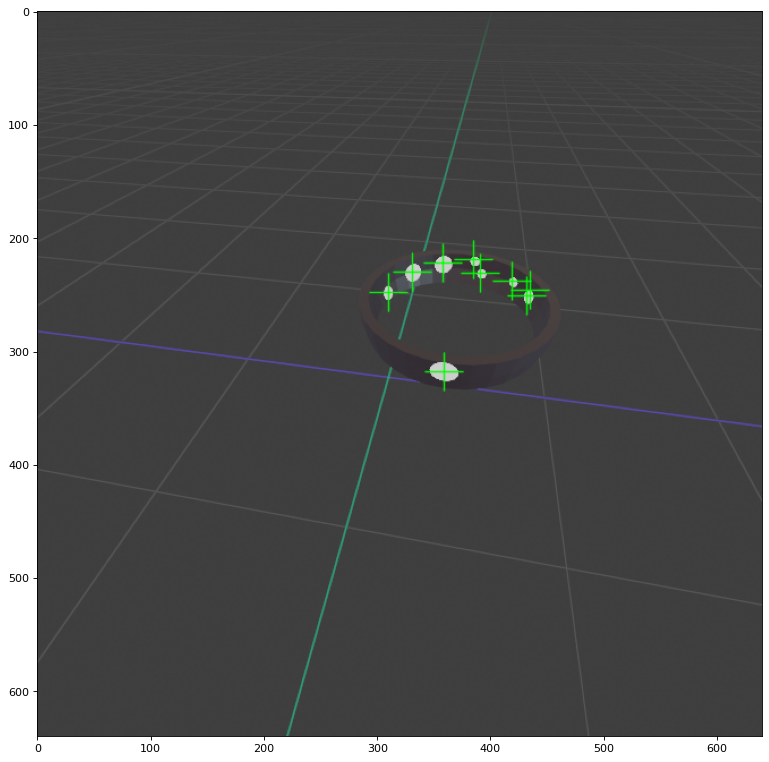

In [8]:
def project_image_points(camera_matrix, rotation_matrix, translation_vector, keypoints3D):
    # Project 3D points onto the image plane to validate results
    projected_image_points = project(camera_matrix, rotation_matrix, translation_vector, keypoints3D)

    img_points = drawMarkers(img, projected_image_points)

    plt.figure(figsize=(16, 12), dpi=80)
    plt.imshow(img_points)
    plt.show() 

    return projected_image_points


projected_image_points = project_image_points(K, rotation_matrix, translation_vector, keypoints3D)

#### Identify incorrect point and measure error rate with the MSE metric

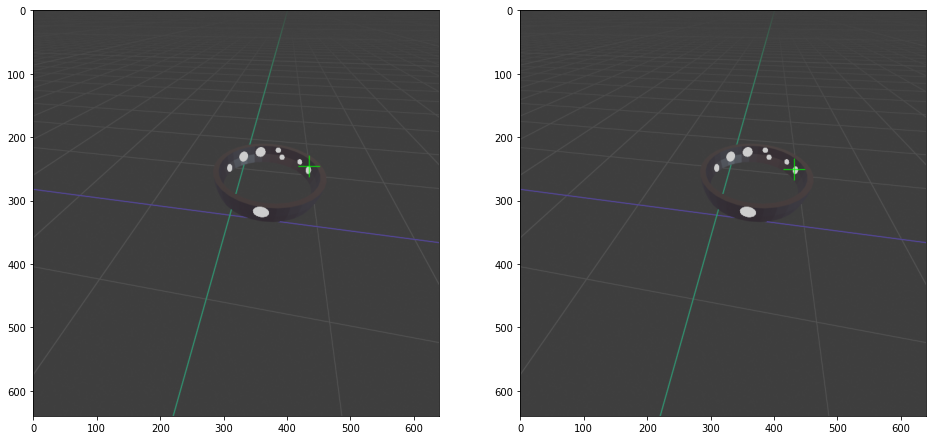

<Figure size 1280x1920 with 0 Axes>

In [9]:
# Two possible incorrect points identified
point1 = np.array([[0.78335, 0.22951, 0.60298]])
point2 = np.array([[0.76461, 0.16558, 0.60724]])

p1 = project(K, rotation_matrix, translation_vector, point1)
p2 = project(K, rotation_matrix, translation_vector, point2)

img_p1 = drawMarkers(img, p1)
img_p2 = drawMarkers(img, p2)

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_size_inches(16, 24)
plt.figure(figsize=(16, 24), dpi=80)
ax1.imshow(img_p1)
ax2.imshow(img_p2)

plt.show() 

#### P1 is the incorrect point, and it will be removed from the keypoints 3D.

In [10]:
def measure_mse(keypoints2D, projected_points):
    # Order points by X
    actual_points = keypoints2D[keypoints2D[:, 0].argsort()]
    projected_points = projected_points[projected_points[:, 0].argsort()] 
        
    mse = np.square(projected_points - actual_points).mean()
    return mse


# Remove Point 1 from keypoints3D
index = np.where(keypoints3D[0, 0] == point1[0, 0])

object_points = np.delete(keypoints3D, index, 0)

projected_points = project(K, rotation_matrix, translation_vector, object_points)

mse = measure_mse(keypoints2D, projected_points)
    
print(f"MSE: {mse}")

MSE: 0.8125


## Get correct points and solve PnP again

Now that we have a good pose estimation with an average error of 0.8px, we can match all the 3D points to the correspondent 2D points and solve the PnP problem again, with an improved estimation and reduced error rate.

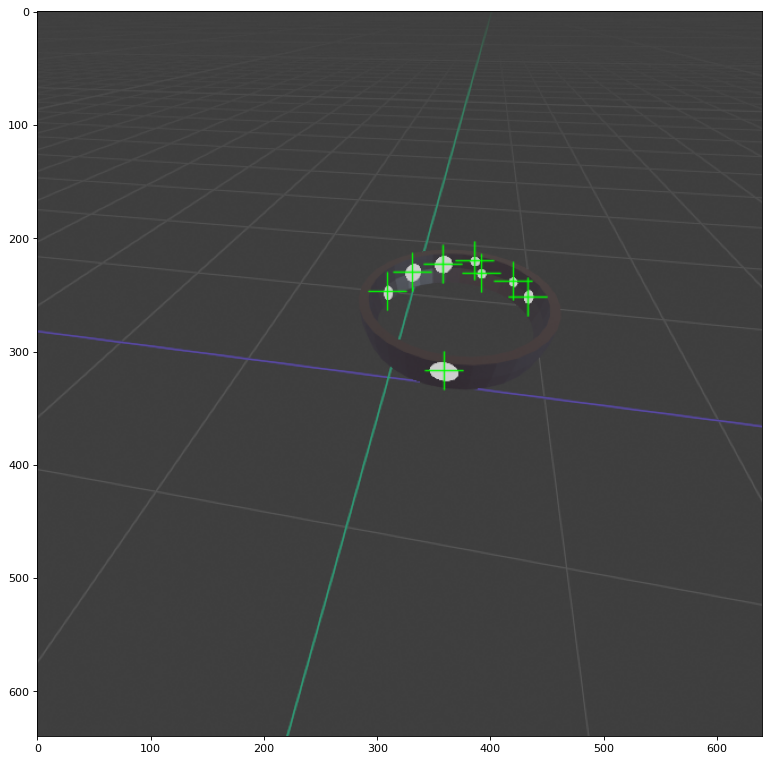

MSE: 0.4375


In [11]:
# Order by X
object_points = object_points[object_points[:, 0].argsort()]
image_points = keypoints2D[keypoints2D[:, 0].argsort()]

rotation_matrix, translation_vector = estimate_pose(object_points, 
                                                    image_points, 
                                                    K,
                                                    cv2.SOLVEPNP_ITERATIVE)

projected_points = project_image_points(K, rotation_matrix, translation_vector, object_points)

mse = measure_mse(keypoints2D, projected_points)
print(f"MSE: {mse}")

By running the pose estimation again with the 8 matching points, and the SOLVEPNP_ITERATIVE algorithm, we are able to **reduce the error rate to 0.4px**. Other PnP algorithms were tested, but they did not present an improved estimation when compared the iterative method.

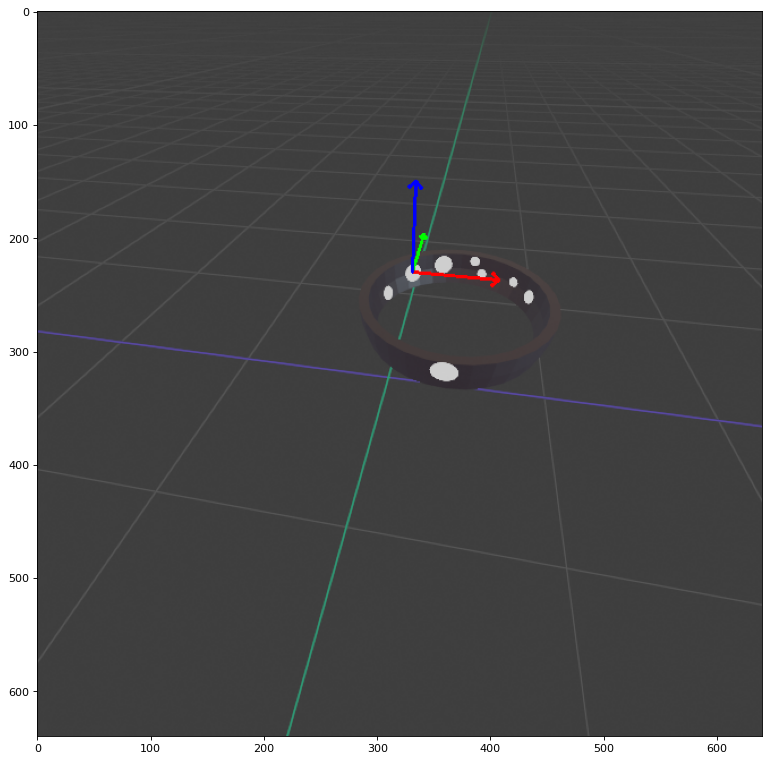

In [12]:
# Display coordinate system
x, y, z = keypoints3D[3]
end_x, end_y, end_z = keypoints3D[3] + 0.5

points = np.array(
    [np.array([x,y,z]), 
     np.array([end_x,y,z]), 
     np.array([x,end_y,z]), 
     np.array([x,y,end_z])]
)

base, x_arrow, y_arrow, z_arrow = project(K, rotation_matrix, translation_vector, points)

img_coordinates = img.copy()

cv2.arrowedLine(img_coordinates, tuple(base),
                tuple(x_arrow), (255,0,0), 2)
cv2.arrowedLine(img_coordinates, tuple(base),
                tuple(y_arrow), (0,255,0), 2)
cv2.arrowedLine(img_coordinates, tuple(base),
                tuple(z_arrow), (0,0,255), 2)

plt.figure(figsize=(16, 12), dpi=80)
plt.imshow(img_coordinates)
plt.show() 

## Estimate the camera pose

In [13]:
from math import atan2, asin

transposed_rotation_matrix = rotation_matrix.transpose()

camera_position = -transposed_rotation_matrix * translation_vector

print(f"Camera position:\n{camera_position}\n")

roll = atan2(-camera_position[2][1], camera_position[2][2])
pitch = asin(camera_position[2][0])
yaw = atan2(-camera_position[1][0], camera_position[0][0])

print(f"Camera orientation:\nRoll = {roll}\nPitch = {pitch}\nYaw = {yaw}")

Camera position:
[[ 0.0779072   0.01033968 -0.00941733]
 [-0.0032906   0.01308744 -0.01285302]
 [-0.01570968  1.68104682  1.71572873]]

Camera orientation:
Roll = -0.7751882740945957
Pitch = -0.01571032500935113
Yaw = 0.04221228618271143
